## Resumo Descritivo do Código
O código realiza a imputação de dados faltantes usando machine learning para prever a quantidade de depósitos irregulares em bairros onde essa informação não está disponível. Ele combina dados socioeconômicos do IBGE com informações específicas sobre depósitos irregulares, aplicando um modelo de Random Forest para estimar os valores ausentes com base nas características demográficas e econômicas dos bairros.

---

O processamento inicia com a leitura e integração de dados de duas fontes distintas:

* Dados do IBGE com indicadores socioeconômicos por bairro

* Dados de dissertação sobre depósitos irregulares

**1. PREPARAÇÃO E ENRIQUECIMENTO DOS DADOS**

* Unificação dos datasets através da chave "Bairro"
* Criação de nova feature CRA (Concentração de Renda por Área)
* Divisão estratégica dos dados:
  * 21 amostras com valores conhecidos (conjunto de treino)
  * 50 amostras com valores faltantes (conjunto de previsão)

**2. MODELAGEM PREDITIVA COM RANDOM FOREST**

* Seleção de features: 10 variáveis preditoras incluindo área, habitantes, moradias, renda, IDH e a nova feature CRA
* Configuração do modelo: RandomForestRegressor com 500 árvores e random_state=42
* Treinamento: Exclusivamente nas 21 amostras com dados completos

**3. AVALIAÇÃO E ANÁLISE DO MODELO**

* Métricas de desempenho no treino:
* R²: 0.8544 (85.44% de variância explicada)
* MAE: 0.8570
* RMSE: 1.2215
* Análise de importância das variáveis: CRA e area_km2 são as features mais relevantes

**4. IMPUTAÇÃO E CONSOLIDAÇÃO FINAL**

* Geração de previsões para os 50 bairros com dados faltantes
* Arredondamento dos valores para números inteiros de depósitos
* Integração dos resultados: Combinação dos valores reais (21) com estimados (50)
* Estatísticas consolidadas: Média de 4.60 depósitos estimados por bairro

**RESULTADO FINAL**

Dataset completo com 71 observações, permitindo análises ambientais e urbanísticas em escala municipal, mesmo para bairros onde não havia coleta direta de dados sobre depósitos irregulares.





In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
import statsmodels.api as sm
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt


### 1. Open file

In [2]:
# Leitura dos dados IBGE
path="/home/akel/PycharmProjects/Data_ambiental/data/process/"
df1 = pd.read_csv(path+'tabela_total_final.csv')

# Leitura dos dados dissertação
path="/home/akel/PycharmProjects/Data_ambiental/data/raw/"
df2 = pd.read_csv(path+'depositos_iregulares.Bairros.csv')


#Verificar consistência de Bairro entre fontes
a=df1['Bairro'].unique().tolist()
A=df2['Bairro'].unique().tolist()
# Novo dataframe df
df = df1.merge(df2, on="Bairro", how="left")
#Nova feature CRA=Concentração de Renda por Área 
df['CRA']=df['Mor/Hab']*df['ren_avg']/df['area_km2']

df.head(5)

,Bairro,area_km2,Hab,Mor,Mor/Hab,N_ren,ren_avg,ren_mdn,T.A.,IDH-R,IDH-L,IDH-E,IDH,Quantidade de Depósitos Irregulares,CRA
0,Batista Campos,1.425387,5795,19062,3.29,11763.0,3742.05,2000.0,99.20,0.869,0.901,0.829,0.866,NaN,8637.191580
1,Canudos,0.798429,3619,13789,3.81,7863.0,1275.72,700.0,98.07,0.751,0.873,0.752,0.790,NaN,6087.571117
2,Cidade Velha,1.474443,3086,12119,3.93,6976.0,1931.71,1000.0,98.64,0.828,0.891,0.802,0.840,3.0,5148.804637
3,Condor,1.822802,10414,42699,4.10,20917.0,845.55,510.0,96.38,0.616,0.769,0.549,0.644,NaN,1901.881942
4,Cremação,1.474000,8324,31257,3.76,17096.0,1769.97,800.0,98.18,0.690,0.825,0.668,0.724,NaN,4514.983583


### 2. Separação de variaveis

In [3]:
# Variáveis (Features) que você está usando
features = ["area_km2", "Hab", "Mor", "Mor/Hab", "N_ren", "ren_avg", "ren_mdn", "T.A.", "IDH",'CRA']
target = "Quantidade de Depósitos Irregulares"

# Cria o conjunto de dados válidos para treino (21 amostras)
df_validas = df.dropna(subset=[target]).copy() #21 amostras
df_missing = df[df[target].isna()].copy()     #~50 amostras sem dados

#df_missing=df.copy()
#df_missing[target]=np.nan

print(f"Amostras para TREINO (válidas): {len(df_validas)}")
print(f"Amostras para PREVISÃO (ausentes): {len(df_missing)}")

Amostras para TREINO (válidas): 21
Amostras para PREVISÃO (ausentes): 50


### 3. Treinamento 


=== Métricas de Treinamento do Ridge Regression (21 Amostras) ===
R² (Coeficiente de Determinação): 0.8544
MAE (Erro Absoluto Médio): 0.8570
RMSE (Raiz do Erro Quadrático Médio): 1.2215


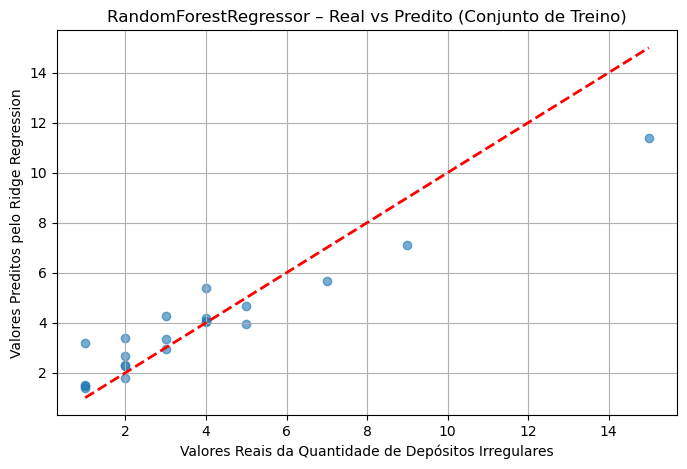


=== Importância das Variáveis (Random Forest) ===
    Feature  Importancia
9       CRA     0.271505
0  area_km2     0.233943
3   Mor/Hab     0.125749
7      T.A.     0.101651
8       IDH     0.083627
2       Mor     0.052999
1       Hab     0.046757
4     N_ren     0.041356
5   ren_avg     0.027122
6   ren_mdn     0.015291


In [4]:
X_train = df_validas[features]
y_train = df_validas[target]
X_predict = df_missing[features] #

# Inicializa o modelo Ridge (simples e regularizado, ideal para 21 amostras)
model_RF = RandomForestRegressor(n_estimators=500, random_state=42)

# Treina o modelo APENAS nas 21 amostras válidas
model_RF.fit(X_train, y_train)

y_pred_train = model_RF.predict(X_train)

# ----------------------------------------------------------------------
## 📈 Métricas de Treinamento
# ----------------------------------------------------------------------
r2 = r2_score(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

print("\n=== Métricas de Treinamento do Ridge Regression (21 Amostras) ===")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")
print(f"MAE (Erro Absoluto Médio): {mae:.4f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")

# ----------------------------------------------------------------------
## 📉 Gráfico de Dispersão (Real vs. Predito)
# ----------------------------------------------------------------------

plt.figure(figsize=(8, 5))
plt.scatter(y_train, y_pred_train, alpha=0.6) 
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2) 
plt.xlabel("Valores Reais da Quantidade de Depósitos Irregulares")
plt.ylabel("Valores Preditos pelo Ridge Regression")
plt.title("RandomForestRegressor – Real vs Predito (Conjunto de Treino)")
plt.grid(True)
plt.show()


# 3. Coeficientes do Modelo
# ⚠️ CORREÇÃO: Usamos .feature_importances_ para Random Forest
importances = model_RF.feature_importances_

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

print("\n=== Importância das Variáveis (Random Forest) ===")
print(feature_importance)

### 4. Estimativas de Descartes

In [5]:
predictions= model_RF.predict(X_predict)

predictions_rounded = np.round(predictions)
predictions_series = pd.Series(predictions_rounded, index=df_missing.index)

df['Depósitos Irregulares est.']=predictions_series

df['Depósitos Irregulares est.'] = (
    df['Depósitos Irregulares est.']
    .fillna(df['Quantidade de Depósitos Irregulares'])
    .astype(int))

print("\n--- Estimação e Imputação Final Concluída (Ridge Regression) ---")
print(f"Total de valores imputados: {len(predictions_rounded)}")
print(f"Média das estimativas imputadas: {np.mean(predictions_rounded):.2f}")
print("-" * 60)
print("Seu DataFrame 'df' agora contém a coluna 'Quantidade de Depósitos Irregulares' completa!")

# Exibe as estatísticas finais da coluna completa
print("\nEstatísticas da Coluna Alvo (21 coletados + ~50 estimados):")
print(df[target].describe())


--- Estimação e Imputação Final Concluída (Ridge Regression) ---
Total de valores imputados: 50
Média das estimativas imputadas: 4.60
------------------------------------------------------------
Seu DataFrame 'df' agora contém a coluna 'Quantidade de Depósitos Irregulares' completa!

Estatísticas da Coluna Alvo (21 coletados + ~50 estimados):
count    21.000000
mean      3.809524
std       3.280534
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max      15.000000
Name: Quantidade de Depósitos Irregulares, dtype: float64


In [6]:
# salvar os novos dados
def salvar_csv(df, caminho):
    if os.path.exists(caminho):
        print(f"⚠️ Arquivo já existe e NÃO será sobrescrito: {caminho}")
    else:
        df.to_csv(caminho, index=False)
        print(f"✅ Arquivo salvo: {caminho}")

path = '/home/akel/PycharmProjects/Data_ambiental/data/process/'
salvar_csv(df, path + 'Descartes_RF.csv')


⚠️ Arquivo já existe e NÃO será sobrescrito: /home/akel/PycharmProjects/Data_ambiental/data/process/Descartes_RF.csv
